# Project 3
Fraud detection. Using dataset from Kaggle.

## Importing Modules

In [37]:
from bs4 import BeautifulSoup
from random import randint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
import time
import pickle
import os
import datetime
import seaborn as sns
import math
import scipy.stats as stats

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report

In [38]:
#Constants
RANDOM_STATE = 999
TEST_SIZE = 0.1


## Data Download and Load Into SQL

Note if you want a copy of the data you can download it from [here](https://www.kaggle.com/ntnu-testimon/paysim1) 

In [39]:
data_df = pd.read_csv("../Data/PS_20174392719_1491204439457_log.csv")

## Data Cleaning

In [40]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [41]:
data_df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [42]:
data_df.shape

(6362620, 11)

In [43]:
data_df.dropna(inplace=True)

In [44]:
data_df.shape

(6362620, 11)

In [45]:
data_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Imbalanced?

In [46]:
data_df["isFraud"].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

**Yes**

## EDA

Initial thought is that `isFraud` is basically a function of `type` and `amount`

one-hot-encoding `type`

In [47]:
ohe = OneHotEncoder(sparse=False)

np_data_type = np.array(data_df["type"])
np_data_type = np_data_type.reshape(-1,1)
np_data_type.shape



(6362620, 1)

In [48]:
np_data_type_ohe = ohe.fit_transform(np_data_type)
np_data_type_ohe.shape

(6362620, 5)

In [49]:
np_data_type_ohe_df= pd.DataFrame(np_data_type_ohe,
                           columns=ohe.get_feature_names(['type']), #create meaningful column names
                           index=data_df.index) #keep the same index values

#np_data_type_ohe_df.head()

#combine continuous and categorical data

data_df = pd.concat([data_df, np_data_type_ohe_df], axis=1)
data_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0.0,0.0,0.0,1.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0.0,0.0,0.0,1.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0.0,0.0,0.0,0.0,1.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0.0,1.0,0.0,0.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0.0,0.0,0.0,1.0,0.0


A plot to help me understand how mixed together `isFraud==0` is with `isFraud==1` as a function of `type` and `amount`

In [50]:
NUM_OF_RANDOM_SAMPLES = 6000

plot_data_df = data_df[["step","isFraud","amount","type_CASH_IN","type_CASH_OUT","type_DEBIT","type_PAYMENT","type_TRANSFER"]]
#limit to the first time step
plot_data_df = plot_data_df[ plot_data_df["step"] == 1 ]
#np_plot_data_df_indices = list(np.random.permutation(np.array(list(plot_data_df.index)))[:5000])
#sns.pairplot(plot_data_df.iloc[[np_plot_data_df_indices]], hue='isFraud');

In [51]:
#This code is generating the index numbers for data frame plot_data_df
#then randomizing the list containing those indices
#then picking the first NUM_OF_RANDOM_SAMPLES from that list
#this list of randomly picked indices will be used to pick the corresponding
#rows out of plot_data_df to be used in the pair plot
#to plot all 6M rows is not practical (on this machine) 
plot_data_df_indices = list(plot_data_df.index)
plot_data_df_indices = np.random.permutation(plot_data_df_indices)
plot_data_df_indices = plot_data_df_indices[:NUM_OF_RANDOM_SAMPLES]
plot_data_df_indices = list(plot_data_df_indices)


In [52]:
 plot_data_df = plot_data_df.iloc[plot_data_df_indices]

In [53]:
plot_data_df.shape

(2708, 8)

In [54]:
plot_data_df.head()

,step,isFraud,amount,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
1197,1,0,223848.92,0.0,0.0,0.0,0.0,1.0
2631,1,0,5843.74,0.0,0.0,0.0,1.0,0.0
676,1,0,10648.06,0.0,0.0,0.0,1.0,0.0
2363,1,0,3697.26,0.0,0.0,0.0,1.0,0.0
751,1,0,3511.45,0.0,0.0,0.0,1.0,0.0


/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping de

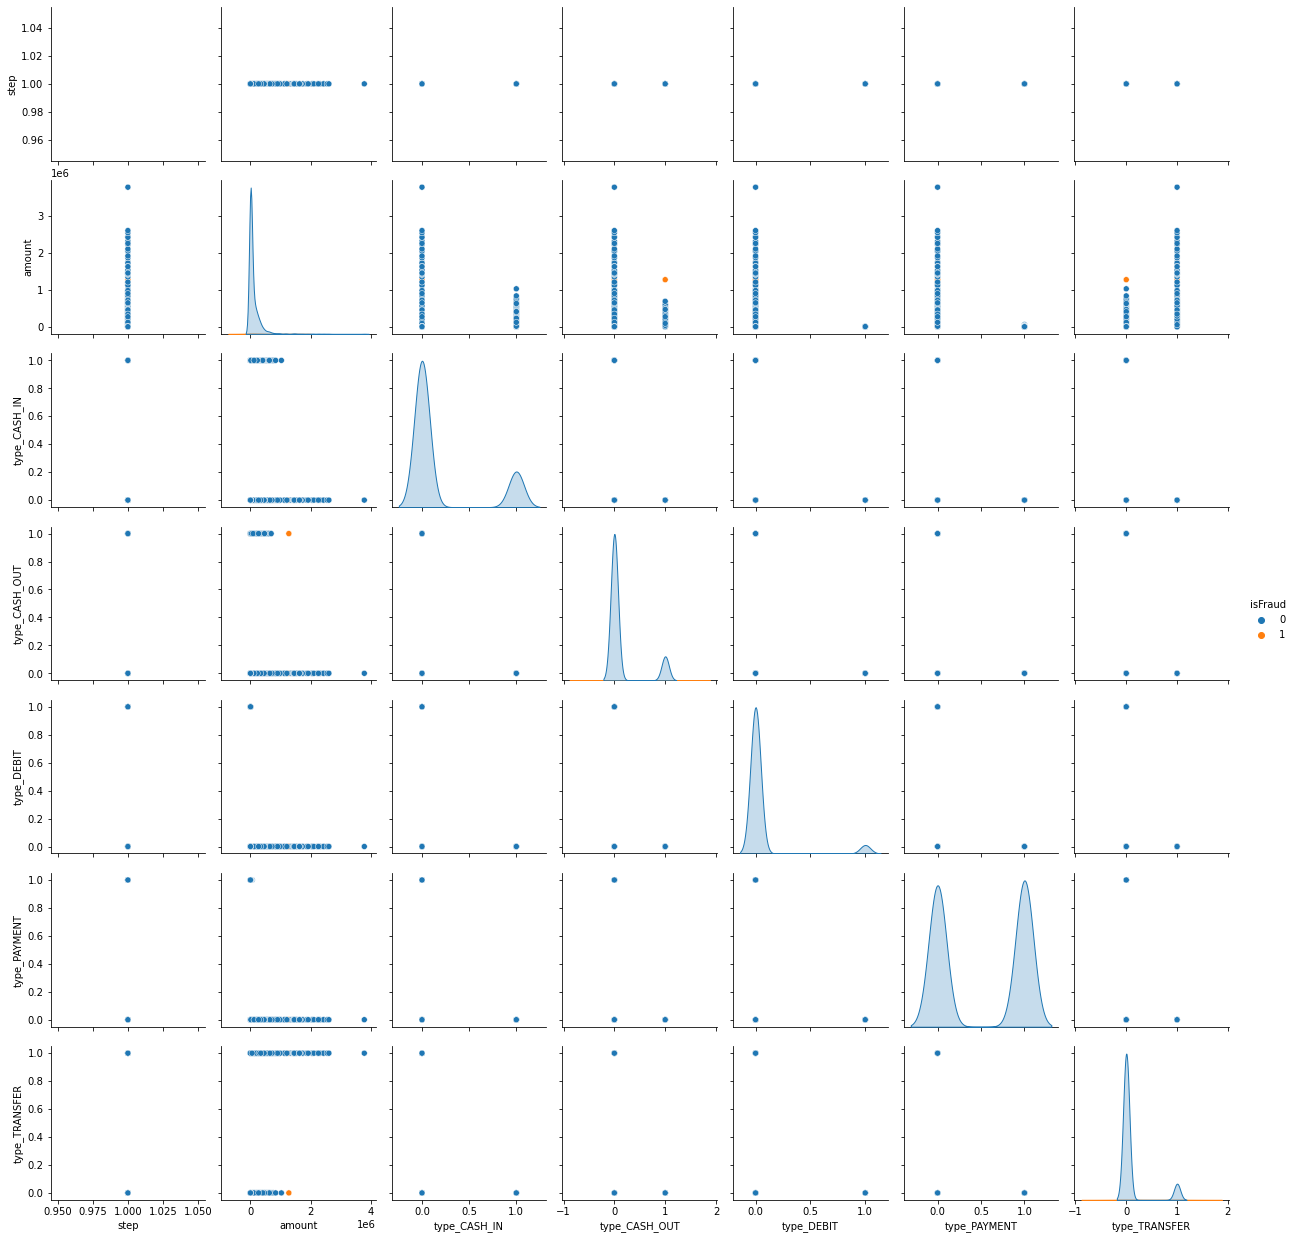

In [55]:
sns.pairplot(plot_data_df, hue='isFraud');

Not looking like good parameters :(

## Baseline Model

Random Guessing (50% chance of `isFraud==1` and 50% chance that `isFraud==0` will be the baseline model

In [56]:
data_df.shape

(6362620, 16)

In [67]:
X = data_df[["step","amount","type_CASH_IN","type_CASH_OUT","type_DEBIT","type_PAYMENT","type_TRANSFER"]]
Y = data_df["isFraud"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=TEST_SIZE, random_state=RANDOM_STATE)

number_of_test_samples = X_test.shape[0]
y_pred_zero = np.zeros(number_of_test_samples // 2)
y_pred_one = np.ones( number_of_test_samples -  y_pred_zero.shape[0] )

y_pred = np.array([y_pred_zero, y_pred_one])
y_pred = y_pred.reshape(-1,)
y_pred = np.random.permutation(y_pred)




Scoring the baseline model

In [68]:
target_names = ["NotFraud","Fraud"]
print(classification_report(Y_test, y_pred,target_names=target_names))

              precision    recall  f1-score   support

    NotFraud       1.00      0.50      0.67    635450
       Fraud       0.00      0.48      0.00       812

    accuracy                           0.50    636262
   macro avg       0.50      0.49      0.33    636262
weighted avg       1.00      0.50      0.67    636262



## Model Selection

Just some notes about what model to select:

**Logistic Models**
For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones.

Note that ‘sag’ and ‘saga’ fast convergence is only guaranteed on features with approximately the same scale. You can preprocess the data with a scaler from sklearn.preprocessing.



## Model Evaluation

In [69]:
#Since I'm using values that are either 1 or 0 along with amount which is a very large number, will normalize the data
#to aid gradient descent
normalizer = StandardScaler()
X_train_normal = normalizer.fit_transform(X_train.values)
X_test_normal = normalizer.transform(X_test.values)

#logisticRModel = LogisticRegressionCV(Cs=100,cv=5,solver="sag",n_jobs=-1,random_state=RANDOM_STATE)
logisticRModel = LogisticRegression(C=100,solver="sag",n_jobs=-1,random_state=RANDOM_STATE)

logisticRModel.fit(X_train_normal,Y_train)

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(C=100, n_jobs=-1, random_state=999, solver='sag')

In [70]:
Y_pred = logisticRModel.predict(X_test_normal)

In [71]:
print(classification_report(Y_test, Y_pred,target_names=target_names))

              precision    recall  f1-score   support

    NotFraud       1.00      1.00      1.00    635450
       Fraud       0.00      0.00      0.00       812

    accuracy                           1.00    636262
   macro avg       0.50      0.50      0.50    636262
weighted avg       1.00      1.00      1.00    636262



In [72]:
logisticRModel.score(X_test_normal,Y_test)

0.9987190811332438

In [73]:
Y_test.value_counts()

0    635450
1       812
Name: isFraud, dtype: int64

In [74]:
Y_pred_df = pd.DataFrame(Y_pred)
Y_pred_df.value_counts()

0    636259
1         3
dtype: int64

In [66]:
logisticRModel.coef_

array([[-0.0108434 ,  0.93611197,  0.02140331, -0.00239537, -0.00369398,
        -0.01941917,  0.01575528, -0.01131935]])